In [1]:
!pip3 install -q -U transformers
!pip3 install -q -U bitsandbytes
!pip3 install -q -U peft
!pip3 install -q -U trl
!pip3 install -q -U accelerate

In [2]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, pipeline, TrainingArguments
from peft import LoraConfig, PeftModel
from trl import SFTTrainer

2024-04-18 07:59:09.021312: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-18 07:59:09.021453: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-18 07:59:09.186799: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
from datasets import Dataset
import pandas as pd
import numpy as np

In [4]:
!pip install -Uq /kaggle/input/sentence-transformers-2-4-0/sentence_transformers-2.4.0-py3-none-any.whl

In [5]:
import numpy as np
import pandas as pd
from tqdm import tqdm
tqdm.pandas()

import warnings 
warnings.filterwarnings('ignore')

from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

In [6]:
from huggingface_hub import login
login("Your HF Code")

Token has not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [7]:
train = pd.read_csv("/kaggle/input/llm-prompt-recovery/train.csv")
test= pd.read_csv("/kaggle/input/llm-prompt-recovery/test.csv")
test_1 = pd.read_csv("/kaggle/input/gemma-rewrite-nbroad/nbroad-v1.csv")
test_2 = pd.read_csv("/kaggle/input/gemma-rewrite-nbroad/nbroad-v2.csv")

In [8]:
len(test_1), len(test_2)

(2166, 2400)

In [9]:
test_c = pd.concat([test_1, test_2])

In [10]:
len(test_c)

4566

In [11]:
#reference: https://www.kaggle.com/code/isakatsuyoshi/improve-the-following-text-below
test_c["pred"] = test_c['rewrite_prompt'] + test_c['original_text'] #dummy prompt

test_c['rewrite_prompt'].sample(2)

2022    Cheerful Optimist: Use the upbeat and positive...
599     Write like Edgar Allan Poe: Adopt the macabre ...
Name: rewrite_prompt, dtype: object

In [12]:
test_c.columns

Index(['id', 'original_text', 'rewrite_prompt', 'rewritten_text', 'pred'], dtype='object')

In [13]:
# def CVScore(test_c):
    
#     scs = lambda row: abs((cosine_similarity(row["actual_embeddings"], row["pred_embeddings"])) ** 3)
    
#     model = SentenceTransformer('/kaggle/input/sentence-t5-base-hf/sentence-t5-base')

#     test_c["actual_embeddings"] = test_c["rewritten_text"].progress_apply(lambda x: model.encode(x, normalize_embeddings=True, show_progress_bar=False).reshape(1, -1))
#     test_c["pred_embeddings"] = test_c["pred"].progress_apply(lambda x: model.encode(x, normalize_embeddings=True, show_progress_bar=False).reshape(1, -1))
    
#     test_c["score"] = test_c.apply(scs, axis=1)
    
#     return np.mean(test_c['score'])[0][0]
    
# print(f"CV Score: {CVScore(test_c)}")

In [14]:
s_model = SentenceTransformer('/kaggle/input/sentence-t5-base-hf/sentence-t5-base')

In [15]:
test_c.drop_duplicates(subset='rewrite_prompt', inplace=True)

In [16]:
scs = lambda row: abs((cosine_similarity(row["actual_embeddings"], row["pred_embeddings"])) ** 3)[0][0]

test_c["actual_embeddings"] = test_c["rewritten_text"].progress_apply(lambda x: s_model.encode(x, normalize_embeddings=True, show_progress_bar=False).reshape(1, -1))
test_c["pred_embeddings"] = test_c["pred"].progress_apply(lambda x: s_model.encode(x, normalize_embeddings=True, show_progress_bar=False).reshape(1, -1))

test_c["score"] = test_c.apply(scs, axis=1)

100%|██████████| 2509/2509 [00:55<00:00, 45.52it/s]


In [17]:
del test_c['actual_embeddings'], test_c['pred_embeddings']

In [18]:
test_c.sort_values(by='score', ascending=False, inplace = True)


In [19]:
len(test_c)

2509

(array([ 54.,  21.,  38.,  62., 114., 146., 180., 237., 247., 291., 313.,
        371., 202., 115.,  58.,  31.,  12.,   7.,   0.,   0.,   1.,   0.,
          2.,   2.,   1.,   1.,   1.,   0.,   0.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([ 113.  ,  281.36,  449.72,  618.08,  786.44,  954.8 , 1123.16,
        1291.52, 1459.88, 1628.24, 1796.6 , 1964.96, 2133.32, 2301.68,
        2470.04, 2638.4 , 2806.76, 2975.12, 3143.48, 3311.84, 3480.2 ,
        3648.56, 3816.92, 3985.28, 4153.64, 4322.  , 4490.36, 4658.72,
        4827.08, 4995.44, 5163.8 , 5332.16, 5500.52, 5668.88, 5837.24,
        6005.6 , 6173.96, 6342.32, 6510.68, 6679.04, 6847.4 , 7015.76,
        7184.12, 7352.48, 7520.84, 7689.2 , 7857.56, 8025.92, 8194.28,
        8362.64, 8531.  ]),
 <BarContainer object of 50 artists>)

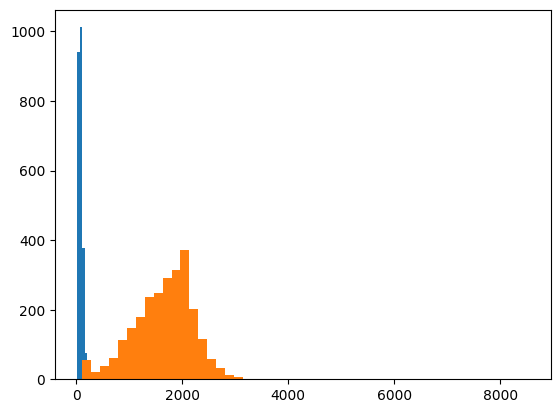

In [20]:
import matplotlib.pyplot as plt

plt.hist([len(x) for x in test_c['rewrite_prompt']])
plt.hist([len(x) for x in test_c['rewritten_text']], bins=50)
# plt.hist([len(x) for x in test_c['original_text']], color='red')

In [21]:
def pd_display(x):
    pd.set_option('display.max_colwidth', x)

In [22]:
pd_display(300)
s_test = test_c[test_c['rewrite_prompt'].str.len() > 100]


(array([  1.,   0.,   0.,   0.,   1.,   1.,   2.,   0.,   0.,   2.,   0.,
          3.,   5.,   2.,   1.,   9.,   6.,  15.,  18.,  31.,  44.,  61.,
         79.,  79., 101.,  75.,  64.,  55.,  20.,  12.]),
 array([0.32956707, 0.35018948, 0.37081188, 0.39143428, 0.41205671,
        0.43267912, 0.45330152, 0.47392392, 0.49454632, 0.51516873,
        0.53579116, 0.55641353, 0.57703596, 0.59765834, 0.61828077,
        0.63890314, 0.65952557, 0.68014801, 0.70077038, 0.72139281,
        0.74201518, 0.76263762, 0.78325999, 0.80388242, 0.82450485,
        0.84512722, 0.86574966, 0.88637203, 0.90699446, 0.92761683,
        0.94823927]),
 <BarContainer object of 30 artists>)

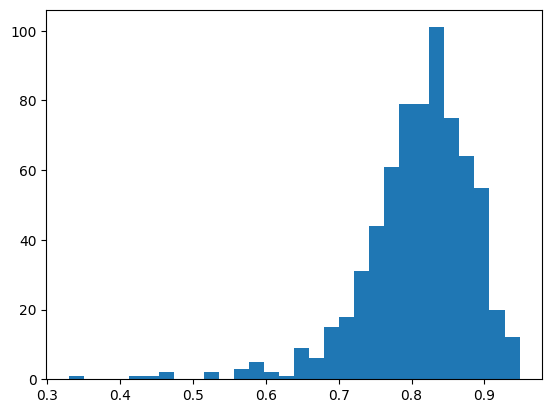

In [23]:
plt.hist(s_test['score'], bins = 30)

In [24]:
s_test = s_test[s_test['score'] > 0.73]
len(s_test)

609

In [25]:
train_data = Dataset.from_pandas(s_test)

In [26]:
def generate_prompt(example):
    prompt_list = []
    for i in range(len(example['original_text'])):
        prompt_list.append(r"""<bos><start_of_turn>user
        original text:
        {},
        rewritten_text:
        {},
        
        Try to understand how the original text was transformed into a new version.
        Analyzing the changes in style, theme, etc., please come up with a prompt that might have been used to guide the proper transformation from the original to the rewritten text.
        
        <end_of_turn>
        
        <start_of_turn>model
        {}<end_of_turn><eos>""".format(example['original_text'][i], example['rewritten_text'][i], example['rewrite_prompt'][i]))
    return prompt_list

In [27]:
from peft import LoraConfig, get_peft_model

lora_config = LoraConfig(
    r=8,
    lora_alpha = 32,
    lora_dropout = 0.05,
    target_modules=["q_proj", "o_proj", "k_proj", "v_proj", "gate_proj", "up_proj", "down_proj"],
    bias="none",
    task_type="CAUSAL_LM",
)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

In [29]:
BASE_MODEL = "google/gemma-2b-it"

model = AutoModelForCausalLM.from_pretrained(BASE_MODEL, device_map={'':0}, quantization_config=bnb_config, )
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL, add_special_tokens=True)
tokenizer.padding_side = 'right'

from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)
model = get_peft_model(model, lora_config)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/34.2k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

In [30]:
import torch
torch.cuda.empty_cache()
import gc

gc.collect()

51

In [31]:
trainer = SFTTrainer(
    model=model,
    train_dataset=train_data,
    max_seq_length=1024,
    args=TrainingArguments(
        output_dir="outputs",
       num_train_epochs = 1,
        max_steps=1000,
        per_device_train_batch_size=1,
        gradient_accumulation_steps=1,
        optim="paged_adamw_8bit",
        warmup_steps=0.03,
        learning_rate=2e-4,
        fp16=True,
        logging_steps=100,
        push_to_hub=False,
        report_to='none',
    ),
    peft_config=lora_config,
    formatting_func=generate_prompt,
)

Map:   0%|          | 0/609 [00:00<?, ? examples/s]

In [32]:
trainer.train()

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Step,Training Loss
100,2.393100
200,2.219400
300,2.190000
400,1.897900
500,1.881800
600,1.824800
700,1.538300
800,1.416900
900,1.463600
1000,1.244300


TrainOutput(global_step=1000, training_loss=1.807027214050293, metrics={'train_runtime': 9924.1588, 'train_samples_per_second': 0.202, 'train_steps_per_second': 0.101, 'total_flos': 2.388625341394944e+16, 'train_loss': 1.807027214050293, 'epoch': 3.28})

In [33]:
ADAPTER_MODEL = "lora_adapter_it"

trainer.model.save_pretrained(ADAPTER_MODEL)

In [34]:
model = AutoModelForCausalLM.from_pretrained(BASE_MODEL, device_map='auto', torch_dtype=torch.float16)
model = PeftModel.from_pretrained(model, ADAPTER_MODEL, device_map='auto', torch_dtype=torch.float16)

model = model.merge_and_unload()
model.save_pretrained('gemma-ko-2b-it')
model.push_to_hub('doxgxxn/gemma_prompt_recovery2')

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/67.1M [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

CommitInfo(commit_url='https://huggingface.co/doxgxxn/gemma_prompt_recovery2/commit/336b93555cfac1fc2e91e728df5daa8e3a687c31', commit_message='Upload GemmaForCausalLM', commit_description='', oid='336b93555cfac1fc2e91e728df5daa8e3a687c31', pr_url=None, pr_revision=None, pr_num=None)